In [136]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import os.path as osp
import time

import matplotlib.pyplot as plt
import mmcv
import numpy as np
import torch


from mmcv import Config, DictAction
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint
from sklearn.manifold import TSNE

import sys
sys.path.append('..')
from mmselfsup.apis import set_random_seed
from mmselfsup.datasets import build_dataloader, build_dataset
from mmselfsup.models import build_algorithm
from mmselfsup.models.utils import BreastUSExtractProcess
from mmselfsup.utils import get_root_logger

In [188]:
cfg = Config.fromfile('/gpfs/data/geraslab/Nan/mmselfsup/configs/benchmarks/classification/nyubreast/us_tsne.py')

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

distributed = False

# create work_dir and init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
tsne_work_dir = osp.join(cfg.work_dir, f'tsne_{timestamp}/')
mmcv.mkdir_or_exist(osp.abspath(tsne_work_dir))
log_file = osp.join(tsne_work_dir, 'extract.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

In [189]:
# build the dataloader
dataset = build_dataset(cfg.data.extract)
# compress dataset, select that the label is less then max_num_class
logger.info(f'Apply t-SNE to visualize {len(dataset)} samples.')
    
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=cfg.data.samples_per_gpu,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=distributed,
    breast=True,
    shuffle=False)


2022-05-10 22:20:40,834 - mmselfsup - INFO - Apply t-SNE to visualize 1000 samples.


In [190]:
# build the model
# cfg.model.type='USTsne'
model = build_algorithm(cfg.model)
model.init_weights()

if not distributed:
    model = MMDataParallel(model, device_ids=[0])
else:
    model = MMDistributedDataParallel(
        model.cuda(),
        device_ids=[torch.cuda.current_device()],
        broadcast_buffers=False)

2022-05-10 22:20:42,454 - mmselfsup - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': '/gpfs/data/geraslab/Nan/saves/selfsup/swav_breast/data_20220111_full/swav_resnet18_milatten1_batch128/us_latest.pth'}
2022-05-10 22:20:42,456 - mmcv - INFO - load model from: /gpfs/data/geraslab/Nan/saves/selfsup/swav_breast/data_20220111_full/swav_resnet18_milatten1_batch128/us_latest.pth
2022-05-10 22:20:42,457 - mmcv - INFO - load checkpoint from local path: /gpfs/data/geraslab/Nan/saves/selfsup/swav_breast/data_20220111_full/swav_resnet18_milatten1_batch128/us_latest.pth
2022-05-10 22:20:42,539 - mmselfsup - INFO - initialize ClsHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'layer': 'Linear'}, {'type': 'Constant', 'val': 1, 'layer': ['_BatchNorm', 'GroupNorm']}]


In [191]:
# build extraction processor and run
extractor = BreastUSExtractProcess()
features = extractor.extract(model, data_loader, distributed=False)
# labels = dataset.data_source.get_gt_labels()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 250/250, 1.0 task/s, elapsed: 253s, ETA:     0s

In [192]:
features['feat'].shape

(11631, 512)

In [178]:
# save features
mmcv.mkdir_or_exist(f'{tsne_work_dir}features/{cfg.name}')
logger.info(f'Save features to {tsne_work_dir}features/')
for key, val in features.items():
    output_file = \
        f'{tsne_work_dir}features/{cfg.name}_{key}.npy'
    np.save(output_file, val)

2022-05-10 22:16:18,044 - mmselfsup - INFO - Save features to /gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/tsne/us/tsne_20220510_220844/features/


In [202]:
def map_func(info):
    if info['biopsied']:
        if info['malignant'] and info['benign']:
            return 1
        elif info['benign']:
            return 2
        elif info['malignant']:
            return 3
        else:
            return 4
    else:
        return 0

def map_func(info):
    if info['malignant']:
        return 1
    elif info['biopsied']:
        return 2
    else:
        return 0
labels = []
mrns = []
for i in range(len(dataset)):
    labels.extend([map_func(dataset.data_source.data_infos[i])]*len(
           dataset.data_source.data_infos[i]['us']['indices'])
        )
    mrns.extend([dataset.data_source.data_infos[i]['mrn']]*len(
            dataset.data_source.data_infos[i]['us']['indices'])
        )


In [203]:
np.unique(labels), len(labels)

(array([0, 1, 2]), 11637)

In [207]:
# build t-SNE model
tsne_model = TSNE(
    n_components=2,
    perplexity=40,
    early_exaggeration=12,
    learning_rate=100,
    n_iter=8000,
    n_iter_without_progress=300,
    metric='cosine',
    square_distances=True,
    verbose=2,
    init='random')


In [208]:
# run and get results
mmcv.mkdir_or_exist(f'{tsne_work_dir}saved_pictures/')
logger.info('Running t-SNE......')
for key, val in features.items():
    result = tsne_model.fit_transform(val[:6000])

2022-05-10 22:32:20,175 - mmselfsup - INFO - Running t-SNE......


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.006s...
[t-SNE] Computed neighbors for 6000 samples in 0.937s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.160761
[t-SNE] Computed conditional probabilities in 0.470s
[t-SNE] Iteration 50: error = 88.2960892, gradient norm = 0.0016344 (50 iterations in 0.661s)
[t-SNE] Iteration 100: error = 87.6887360, gradient norm = 0.0030000 (50 iterations in 0.587s)
[t-SNE] Iteration 150: error = 86.5858002, gradient norm = 0.0002033 (50 iterations in 0.671s)
[t-SNE] Iteration 200: error = 86.5465317, gradient norm = 0.0000862 (50 iterations in 0.616s)
[

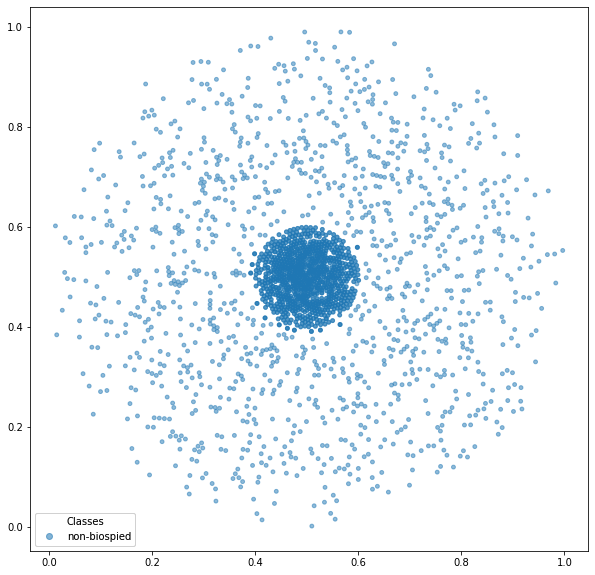

In [205]:
res_min, res_max = result.min(0), result.max(0)
res_norm = (result - res_min) / (res_max - res_min)

fig, ax = plt.subplots(figsize=(10, 10)) 
sc = ax.scatter(
    res_norm[:, 0],
    res_norm[:, 1],
    alpha=0.5,
    s=15,
    c=labels[:6000],
    cmap='tab20')

# produce a legend with a cross section of sizes from the scatter
legend1 = ax.legend(sc.legend_elements()[0], ['non-biospied', 'malignant', 'biopsied'],
               # ['non-biospied', 'both', 'benign', 'malignant', 'other'],
                    loc="lower left", title="Classes")
ax.add_artist(legend1)


plt.savefig(f'{tsne_work_dir}saved_pictures/{key}.png')

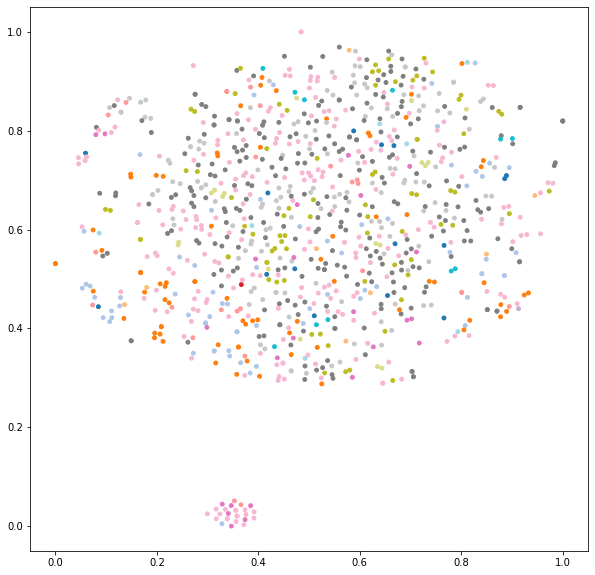

In [184]:
plt.figure(figsize=(10, 10))
plt.scatter(
    res_norm[:, 0],
    res_norm[:, 1],
    alpha=1.0,
    s=15,
    c=mrns,
    cmap='tab20')
plt.savefig(f'{tsne_work_dir}saved_pictures/{key}.png')
